# Maximisation-expectation

Notebook configuration

In [1]:
from os import getcwd, chdir

# set the current working directory to the repository's root, if required
if getcwd().endswith('notebooks'):
    chdir('./../')

In [2]:
!python -m pip install tabulate
from IPython.display import display
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

def display_horizontaly_two_tables(df:pd.DataFrame,df2:pd.DataFrame, title1:str, title2:str):
    df_md = df.to_markdown().split('\n')
    df2_md = df2.to_markdown().split('\n')
    title_line = title1 + " " * (len(df_md[0])-len(title1)) + "\t" + title2
    two_tabs = "\n".join([title_line] + [df_md[i] + '\t' + df2_md[i] for i in range(len(df_md))])
    print(two_tabs)


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Initial Dataset

In [3]:
from data.getDataset import getCognatesSet, getIteration
from data.vocab import computeInferenceData, V_SIZE
from torch.nn.utils.rnn import pad_sequence
from Types.articleModels import ModernLanguages
from Types.models import InferenceData
from Source.reconstructionModel import ReconstructionModel

cognates:dict[ModernLanguages, InferenceData] = {lang:computeInferenceData(pad_sequence(cogSet, batch_first=False)) for (lang, cogSet) in getCognatesSet().items()}
currentReconstructions = computeInferenceData(pad_sequence(getIteration(1), batch_first=False).unsqueeze(-1))

voc_size = V_SIZE
LSTM_INPUT_DIM = 50
LSTM_HIDDEN_DIM = 50

randomEditModel = ReconstructionModel(cognates, voc_size, LSTM_INPUT_DIM, LSTM_HIDDEN_DIM)

TEST_LANGUAGE:ModernLanguages = "french"
x_maxLength = currentReconstructions[0].size()[0] - 2
y_maxLength = cognates[TEST_LANGUAGE][0].size()[0] - 2
print('|y| max =', y_maxLength)
print('|x| max =', x_maxLength)

|y| max = 18
|x| max = 16


## Backward dynamic Program

Inference in edit model

In [4]:
randomEditModel.update_modernForm_context()

Backward dynamic Program

In [5]:
targets_prob = randomEditModel.backward_dynProg(currentReconstructions)

### Analysis

Test on $x :=$`"absyrdʊ"` and $y :=$`"absˈyʁd"` ($|x|=7$ and $|y|=7$)

In [6]:
IDX = 20 # the index in the batch of the sample to be studied
x_length, y_length = 7, 7

backward_prob_dlt = targets_prob[TEST_LANGUAGE].dlt[:,:,IDX].cpu().numpy().squeeze(-1)
backward_prob_end = targets_prob[TEST_LANGUAGE].end[:,:,IDX].cpu().numpy().squeeze(-1)
backward_prob_sub = targets_prob[TEST_LANGUAGE].sub[:,:,IDX].cpu().numpy().squeeze(-1)
backward_prob_ins = targets_prob[TEST_LANGUAGE].ins[:,:,IDX].cpu().numpy().squeeze(-1)

#### Display of cached probabilities for the substitution and the deletion operations

Notice that the logarithmic probabilities that have not to be defined for these operations are automatically set to $-\infty{}$ thanks to the recurrence mathematical relations of the backward dynamic program. So do the undefined probabilities in padding positions, thanks to the neutrality of edit model's cached inference probabilities (which equal $0$ in the log space).

In [7]:
df = pd.DataFrame(backward_prob_sub[:x_length+2, :y_length+2])
df2 = pd.DataFrame(backward_prob_dlt[:x_length+2, :y_length+2])

display_horizontaly_two_tables(df, df2, "Subsitution Operation", "Deletion Operation")

Subsitution Operation                                                                                	Deletion Operation
|    |        0 |        1 |        2 |        3 |        4 |        5 |        6 |      7 |      8 |	|    |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 |      8 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|-------:|-------:|	|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|-------:|
|  0 | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -2e+09 | -2e+09 |	|  0 | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -1e+09   | -2e+09 |
|  1 | -1.46277 | -2.06448 | -2.6901  | -3.7001  | -4.3989  | -5.58043 | -7.9897  | -1e+09 | -1e+09 |	|  1 | -1.42681 | -1.9572  | -2.62007 | -3.1898  | -3.75215 | -4.57969 | -5.73576 | -8.2258  | -1e+09 |
|  2 | -1.91928 | -1.96403 | -2.23038 | -2.82901 | -3.2

## Rendering of the target and the logits before the loss computation

In [8]:
MINI_BATCH_SIZE = 30

miniBatchDataForLogitsComputation, miniBatchTargetsLoad = list(zip(*randomEditModel.renderMiniBatchData(currentReconstructions, targets_prob, MINI_BATCH_SIZE)))[0]
renderedTargets = miniBatchTargetsLoad[:,IDX,:]
renderedLogits = randomEditModel.renderLogitsForMiniBatch(*miniBatchDataForLogitsComputation)[:,IDX,:].detach()
print("Targets load shape:", renderedTargets.size())
print("Logits load shape:", renderedLogits.size())

Targets load shape: torch.Size([858, 118])
Logits load shape: torch.Size([858, 118])


In [9]:
maxModernSequenceLength_inMiniBatch: dict[ModernLanguages, int] = {lang:data[2] for (lang, data) in miniBatchDataForLogitsComputation[1].items()} #type:ignore
maxSampleSequenceLength_inMiniBatch: int = miniBatchDataForLogitsComputation[0][2]+1
renderedTargets = renderedTargets.split([maxModernSequenceLength_inMiniBatch[lang]*maxSampleSequenceLength_inMiniBatch for lang in randomEditModel.languages])[randomEditModel.languages.index(TEST_LANGUAGE)].view(maxSampleSequenceLength_inMiniBatch, maxModernSequenceLength_inMiniBatch[TEST_LANGUAGE], voc_size*2+2).cpu().numpy()
renderedLogits = renderedLogits.split([maxModernSequenceLength_inMiniBatch[lang]*maxSampleSequenceLength_inMiniBatch for lang in randomEditModel.languages])[randomEditModel.languages.index(TEST_LANGUAGE)].view(maxSampleSequenceLength_inMiniBatch, maxModernSequenceLength_inMiniBatch[TEST_LANGUAGE], voc_size*2+2).cpu().numpy()

print(renderedTargets.shape)
print(renderedLogits.shape)

(11, 14, 118)
(11, 14, 118)


#### Comparison of the rendered target probs format and the cached probs format

A reduction of the renderedTargets has been done for the displaying. The comparison is done for the insertion and the ending operations.

In [10]:
df_insBackward = pd.DataFrame(backward_prob_ins[:x_length+2, :y_length+2])
df_endBackward = pd.DataFrame(backward_prob_end[:x_length+2, :y_length+2])
df_insRenderedTargets = pd.DataFrame(renderedTargets[:x_length+2, :y_length+2, -V_SIZE-1:-1].sum(axis=2))
df_endRenderedTargets = pd.DataFrame(renderedTargets[:x_length+2, :y_length+2, -1])
df_insRenderedLogits = pd.DataFrame(renderedLogits[:x_length+2, :y_length+2, -V_SIZE-1:-1].sum(axis=2))
df_endRenderedLogits = pd.DataFrame(renderedLogits[:x_length+2, :y_length+2, -1])

display_horizontaly_two_tables(df_insBackward, df_endBackward, "Insertion operation - cached posterior probs", "Ending operation - cached posterior probs")
display_horizontaly_two_tables(df_insRenderedTargets, df_endRenderedTargets, "Insertion operation - rendered target probs", "Ending operation - rendered target probs")
display_horizontaly_two_tables(df_insRenderedLogits, df_endRenderedLogits, "Insertion operation - rendered logits", "Ending operation - rendered logits")

# display(pd.merge(df_insBackward, df_endBackward, left_index=True, right_index=True, suffixes=(' ins', ' end')),
#         pd.merge(df_insRenderedTargets, df_endRenderedTargets, left_index=True, right_index=True, suffixes=(' ins', ' end'))
#         )

Insertion operation - cached posterior probs                                                         	Ending operation - cached posterior probs
|    |        0 |        1 |        2 |        3 |        4 |        5 |        6 |      7 |      8 |	|    |         0 |        1 |        2 |        3 |        4 |        5 |        6 |         7 |      8 |
|---:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|-------:|-------:|	|---:|----------:|---------:|---------:|---------:|---------:|---------:|---------:|----------:|-------:|
|  0 | -0.63803 | -1.34632 | -2.12424 | -2.92579 | -4.02496 | -5.56358 | -8.2258  | -1e+09 | -1e+09 |	|  0 | -0.751485 | -1.31626 | -1.96132 | -2.7196  | -3.33098 | -4.26663 | -5.63593 | -8.2258   | -1e+09 |
|  1 | -1e+09   | -2.11327 | -2.12825 | -2.37639 | -3.13917 | -4.29327 | -6.46216 | -1e+09 | -1e+09 |	|  1 | -1e+09    | -2.20047 | -2.05042 | -2.3641  | -2.59981 | -3.17129 | -4.14334 | -6.26572  | -1e+09 |
|  2 | -1e+09   | -2.462

## Training round

Epoch 1
------------------------------------------------------------
Average loss: -0.525705 ; Standard deviation: 1.252229          
------------------------------------------------------------

Epoch 2
------------------------------------------------------------
Average loss: -1.799143 ; Standard deviation: 0.449534          
------------------------------------------------------------

Epoch 3
------------------------------------------------------------
Average loss: -2.206631 ; Standard deviation: 0.493868          
------------------------------------------------------------

Epoch 4
------------------------------------------------------------
Average loss: -2.451300 ; Standard deviation: 0.526853          
------------------------------------------------------------

Epoch 5
------------------------------------------------------------
Average loss: -2.610863 ; Standard deviation: 0.550287          
------------------------------------------------------------

Figure(640x480)


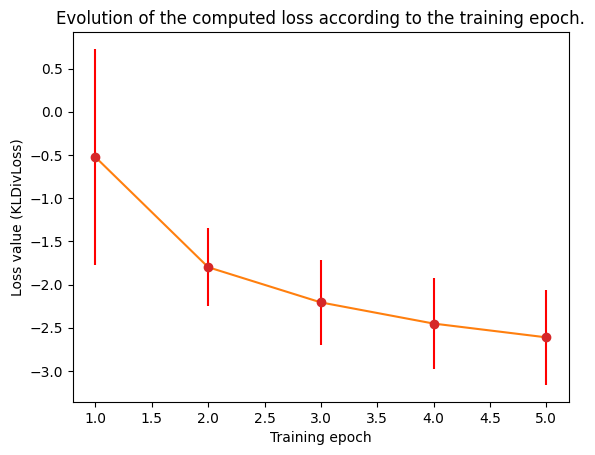

In [11]:
EPOCHS, LEARNING_RATE = 5, 0.01
randomEditModel.train_models(currentReconstructions, targets_prob, MINI_BATCH_SIZE, EPOCHS, LEARNING_RATE)